# Transfer Learning - MNIST Data Set

## Overview

Illustrates transfer learning based on Keras and Theano packages.

Structure of the notebook:
* Obtain the MNIST data set
* Split the MNIST data set into even digit data set and odd digit data set
* Prepare image data for modeling, one-hot encode the digit label
* Define feature detection and classification layers for the CNN model
* Train even digit CNN model to recognize even digits and save model structure to disk
* Evaluate model performance against even and odd digit test data sets
* Create odd digit CNN model structure from the even digit model CNN
* Freeze feature detection layers of the odd digit CNN model
* Train CNN model with frozen feature detection layer to recognize odd digits
* Evaluate model performance against odd and even test data sets

## Setup

In [1]:
# configuration and profiling
import time
import os

# set up backend theano or tensorflow
os.environ['KERAS_BACKEND'] = 'theano'
#os.environ['KERAS_BACKEND'] = 'tensorflow'

# set up theano cpu/gpu
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cuda,floatX=float32"
#os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=gpu,floatX=float32,dnn.enabled=True"

In [2]:
# Import required libraries
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using Theano backend.
Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GT 750M (0000:01:00.0)


## Obtain MNIST Data Set

In [3]:
from keras.datasets import mnist

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Create even/odd data sets

In [4]:
# split into odd and evens
odds = [i for i,j in enumerate(y_train) if j % 2 == 1 ]
evens = list(set(range(len(y_train))) - set(odds))

X_train_odd = X_train[odds]
y_train_odd = y_train[odds]

X_train_even = X_train[evens]
y_train_even = y_train[evens]

# split into odd and evens
odds = [i for i,j in enumerate(y_test) if j % 2 == 1 ]
evens = list(set(range(len(y_test))) - set(odds))

X_test_odd = X_test[odds]
y_test_odd = y_test[odds]

X_test_even = X_test[evens]
y_test_even = y_test[evens]

## Prepare data for modeling

In [5]:
###
# function to prepare data for modeling
###
def prepareFeatureSet(X_in,y_in):
    # reshape to be [samples][channels][width][height]
    X_out = X_in.reshape(X_in.shape[0], 1, 28, 28).astype('float32')

    # normalize inputs from 0-255 to 0-1
    X_out = X_out / 255
    
    #one-hot encode target variable
    min_y = min(y_in)
    num_classes = len(np.unique(y_in))
    y_out = np_utils.to_categorical((y_in-min_y)/2,num_classes)
    
    return((X_out,y_out))
    

In [6]:
###
# Prepare data for modeling
###
X_train_even_mdl, y_train_even_mdl = prepareFeatureSet(X_train_even,y_train_even)
X_test_even_mdl, y_test_even_mdl = prepareFeatureSet(X_test_even, y_test_even)

X_train_odd_mdl, y_train_odd_mdl = prepareFeatureSet(X_train_odd,y_train_odd)
X_test_odd_mdl, y_test_odd_mdl = prepareFeatureSet(X_test_odd, y_test_odd)

## Plot sample images

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotDigitGrid(X,y,idxs,y_hat=None):
    plt.figure(figsize=(9,9))

    for i in range(len(idxs)):
        plt.subplot(4,4,i+1)
        
        if y_hat is None:
            plt.title('Label: {label}'.format(label=y[idxs[i]]))
        else:
            plt.title("Label: {label}  Pred: {pred}".format(label=y[idxs[i]], pred=y_hat[idxs[i]]))
            
        plt.imshow(X[idxs[i]], cmap='Greys')
        plt.tick_params(
            axis='both',          # changes apply to the x-axis and y-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # tick marks on bottom side are off
            left='off',        # tick marks on left side are off
            labelleft='off',   # label on left side are off
            labelbottom='off') # labels along the bottom edge are off

    plt.show()


## Plot Sample Even Digits

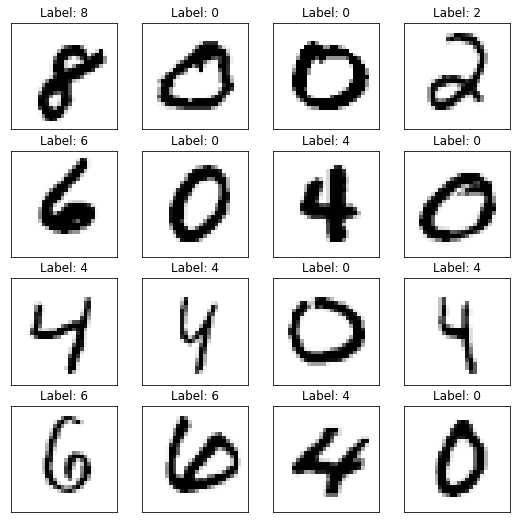

In [8]:
np.random.seed(127)
idxs_even = np.random.choice(y_test_even.shape[0],16)

plotDigitGrid(X_test_even,y_test_even,idxs_even)

## Plot Sample Odd Digits

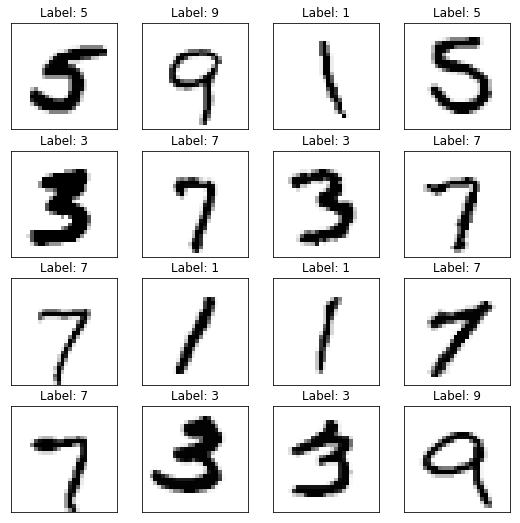

In [9]:
np.random.seed(127)
idxs_odd = np.random.choice(y_test_odd.shape[0],16)

plotDigitGrid(X_test_odd,y_test_odd,idxs_odd)

## Set up for model training

In [10]:
###
# function to train model
###
def train_model(model, x_train, y_train, x_test, y_test):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    t = time.time()
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %.3f (sec)' % (time.time() - t))


## Define CNN Model architecture

In [11]:
###
# define two groups of layers: feature (convolutions) and classification (dense)
###
feature_layers = [
    Convolution2D(30, 5,
           padding='valid',
           input_shape=(1,28,28),activation='relu'),
    Convolution2D(15, 5, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(5,activation='softmax')
]



## Global parameters for training

In [12]:
BATCH_SIZE = 128

EPOCHS = 5

np.random.seed(13)

## Train Even Digit Model

In [13]:
###
# Train Model
###

# define baseline model
even_digit_model = Sequential(feature_layers + classification_layers)

# train model for even digits
train_model(even_digit_model,X_train_even_mdl, y_train_even_mdl, X_test_even_mdl, y_test_even_mdl)

Train on 29492 samples, validate on 4926 samples
Epoch 1/5
29492/29492 [==============================] - 17s - loss: 0.2433 - acc: 0.9200 - val_loss: 0.0512 - val_acc: 0.9823

In [14]:
even_digit_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 24, 24)        780       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 20, 20)        11265     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 10, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 10, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               192128    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## Save Even Digit Model

In [15]:
###
# save model to disk
###
# serialize model structure to JSON
model_json = even_digit_model.to_json()
with open('./even_digit_model.json', "w") as json_file:
    json_file.write(model_json)

    
# serialize model weights to HDF5
even_digit_model.save_weights("./even_digit_model.h5")

## Even Digit Model - Evaluate Model on Even Digit Test Data Set

In [16]:
# report performance on even digit test data set
score = even_digit_model.evaluate(X_test_even_mdl, y_test_even_mdl, verbose=0)
print('\nTest Loss:', score[0])
print('Test accuracy:', score[1])


Test Loss: 0.0207954880156
Test accuracy: 0.992082825822


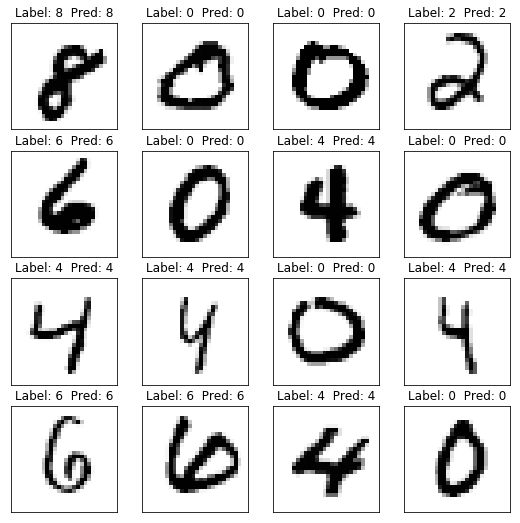

In [17]:
y_hat = even_digit_model.predict_classes(X_test_even_mdl,verbose=0)

plotDigitGrid(X_test_even,y_test_even,idxs_even,y_hat=2*y_hat)

## Even Digit Model - Evaluate Model on Odd Digit Test Data Set

In [18]:
score = even_digit_model.evaluate(X_test_odd_mdl, y_test_odd_mdl, verbose=0)
print('\nTest Loss:', score[0])
print('Test accuracy:', score[1])


Test Loss: 6.7956510934
Test accuracy: 0.13480488768


4864/5074 [===========================>..] - ETA: 0s

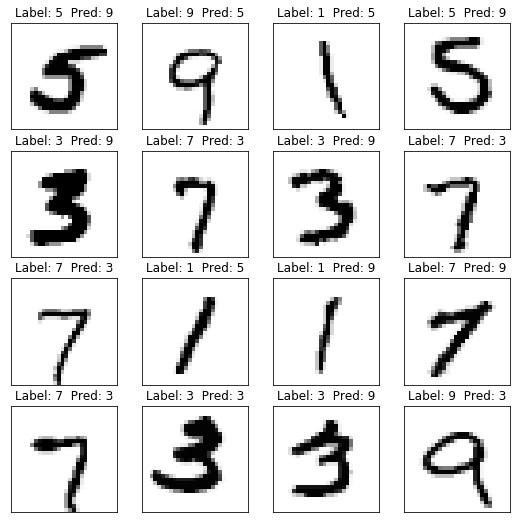

In [19]:
y_hat = even_digit_model.predict_classes(X_test_odd_mdl)

plotDigitGrid(X_test_odd,y_test_odd,idxs_even,y_hat=2*y_hat+1)

## Transfer Learning
## Initialize Odd Digit Model from Even Digit Model

In [20]:
###
# recerate model structure
###
from keras.models import model_from_json

# load json and create model
json_file = open('./even_digit_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

# define cnn structure from the even_digit_model
odd_digit_model = model_from_json(loaded_model_json)

# load weights into new model
odd_digit_model.load_weights('./even_digit_model.h5')

## Report Structure on Odd Digit Model Structure

In [21]:
for layer in odd_digit_model.layers:
    layer_name = layer.name
    layer_type = layer.__class__.__name__
    layer_trainable_flag = layer.trainable
    print (layer.name, layer_type, layer_trainable_flag)

conv2d_1 Conv2D True
conv2d_2 Conv2D True
max_pooling2d_1 MaxPooling2D True
dropout_1 Dropout True
flatten_1 Flatten True
dense_1 Dense True
dropout_2 Dropout True
dense_2 Dense True


## Freeze Feature Detection Layers

In [22]:
###
# Convoluation and MaxPooling Layers
###
for layer in odd_digit_model.layers:
    if layer.__class__.__name__ != 'Dense':
        layer.trainable = False

In [23]:
for layer in odd_digit_model.layers:
    layer_name = layer.name
    layer_type = layer.__class__.__name__
    layer_trainable_flag = layer.trainable
    print (layer.name, layer_type, layer_trainable_flag)

conv2d_1 Conv2D False
conv2d_2 Conv2D False
max_pooling2d_1 MaxPooling2D False
dropout_1 Dropout False
flatten_1 Flatten False
dense_1 Dense True
dropout_2 Dropout False
dense_2 Dense True


In [24]:
# Compile model
odd_digit_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Odd Digit Model

In [25]:
train_model(odd_digit_model,X_train_odd_mdl, y_train_odd_mdl, X_test_odd_mdl, y_test_odd_mdl)

Train on 30508 samples, validate on 5074 samples
Epoch 1/5
30508/30508 [==============================] - 5s - loss: 0.5351 - acc: 0.8600 - val_loss: 0.0788 - val_acc: 0.9762

In [26]:
odd_digit_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 24, 24)        780       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 20, 20)        11265     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 10, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 10, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               192128    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## Odd Digit Model - Evaluate Model on Odd Digit Test Data Set

In [27]:
score = odd_digit_model.evaluate(X_test_odd_mdl, y_test_odd_mdl, verbose=0)
print('\nTest Loss:', score[0])
print('Test accuracy:', score[1])


Test Loss: 0.0332411218591
Test accuracy: 0.988766259361


5024/5074 [============================>.] - ETA: 0s

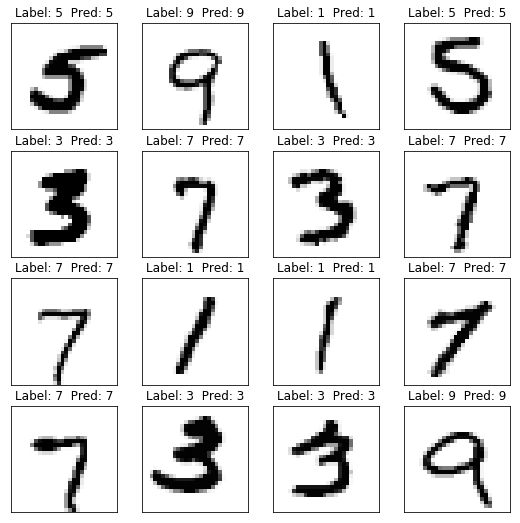

In [28]:
y_hat = odd_digit_model.predict_classes(X_test_odd_mdl)

plotDigitGrid(X_test_odd,y_test_odd,idxs_even,y_hat=2*y_hat+1)

## Odd Digit Model - Evaluate Even Digit Test Data Set

In [29]:
# report performance on even digit test data set
score = odd_digit_model.evaluate(X_test_even_mdl, y_test_even_mdl, verbose=0)
print('\nTest Loss:', score[0])
print('Test accuracy:', score[1])


Test Loss: 4.31423670598
Test accuracy: 0.270401948915


4640/4926 [===========================>..] - ETA: 0s

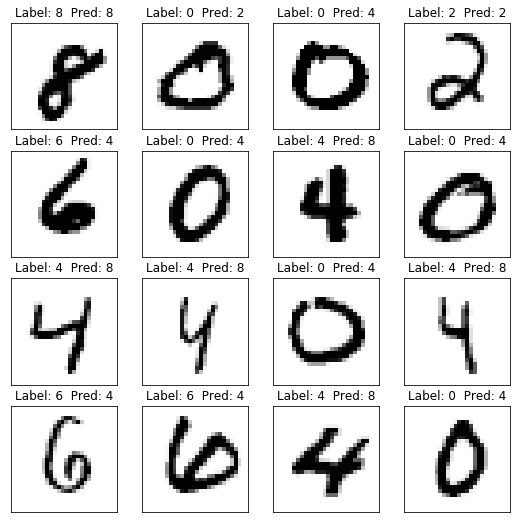

In [30]:
y_hat = odd_digit_model.predict_classes(X_test_even_mdl)

plotDigitGrid(X_test_even,y_test_even,idxs_even,y_hat=2*y_hat)